In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### Global variables

In [2]:
MSS = 'MSS_only'

### Load data

In [3]:
# load confident patients
confident_patientsI = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_I.age_sex_disease.MSS_only.kept_sex_specific.txt', sep='\t', index_col=0)
confident_patientsII = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_II.age_sex_disease.MSS_only.kept_sex_specific.txt', sep='\t', index_col=0)

In [4]:
# find MSS patients that are MHC mutated (non-silent)
mhc_mut_patients = np.loadtxt('/cellar/users/andreabc/Data/b2m/mss_B2M_patients.txt', dtype=str).tolist()
mhc_mut_patients.extend(np.loadtxt('/cellar/users/andreabc/Data/b2m/mss_HLA_patients.txt', dtype=str))

mut_confident_patientsI = confident_patientsI[confident_patientsI.index.isin(mhc_mut_patients)]
mut_confident_patientsII = confident_patientsII[confident_patientsII.index.isin(mhc_mut_patients)]

unmut_confident_patientsI = confident_patientsI[~confident_patientsI.index.isin(mhc_mut_patients)]
unmut_confident_patientsII = confident_patientsII[~confident_patientsII.index.isin(mhc_mut_patients)]

total_confident_patientsI = mut_confident_patientsI.append(unmut_confident_patientsI)
total_confident_patientsI['MHC_mutation'] = [1]*len(mut_confident_patientsI) + [0]*len(unmut_confident_patientsI)

total_confident_patientsII = mut_confident_patientsII.append(unmut_confident_patientsII)
total_confident_patientsII['MHC_mutation'] = [1]*len(mut_confident_patientsII) + [0]*len(unmut_confident_patientsII)

# set age threshold
young_thresh = 52 # 30th percentile: 52, 40th: 57
old_thresh = 68   # 70th percentile: 68, 60th: 65

total_confident_patientsI['age_categorical_3070'] = pd.cut(total_confident_patientsI['age'], [0, young_thresh, old_thresh, total_confident_patientsI['age'].max()], labels=['younger', 'middle', 'older'])
total_confident_patientsII['age_categorical_3070'] = pd.cut(total_confident_patientsII['age'], [0, young_thresh, old_thresh, total_confident_patientsII['age'].max()], labels=['younger', 'middle', 'older'])

print('{}, {} nonsynonymous MHC-I mutated patients'.format(len(mut_confident_patientsI), len(mut_confident_patientsII)))

508, 422 nonsynonymous MHC-I mutated patients


#### Sex/age distributions for MHC-I mutated patients

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/MHC_mut.sex_age_counts.MSS_only.pdf


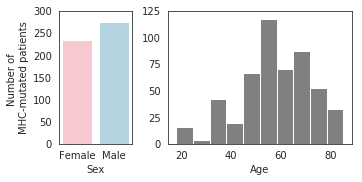

In [11]:
plt.figure(figsize=(5,2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 3]) 

# A - pancancer sex counts
plt.subplot(gs[0])
data = pd.DataFrame(mut_confident_patientsI['sex'].value_counts()).T
sns.barplot(data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('Sex')
plt.ylabel('Number of \nMHC-mutated patients')
plt.xticks([0,1], ['Female', 'Male'])
plt.ylim(0,300)


# B - pancancer age distribution
plt.subplot(gs[1])
data = mut_confident_patientsI.copy()
plt.hist(x=data['age'].values, bins=10, color='grey')
plt.xlabel('Age')
plt.ylabel('')
plt.ylim(0,125)

plt.tight_layout(pad=0.6, h_pad=1)

savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/MHC_mut.sex_age_counts.{}.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath)
plt.show()

#### PHBR boxplots

In [5]:
from scipy.stats import mannwhitneyu

In [6]:
sex_specific_cancers = ['TCGT', 'OV', 'PRAD', 'UCEC', 'CESC', 'UCS', 'BRCA']

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/1_PHBR_boxplots.MHC_mutated_patients.pdf


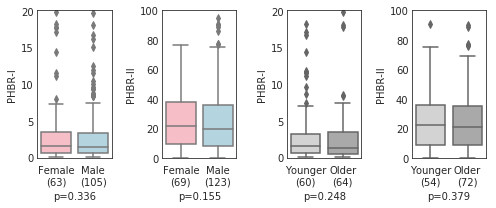

In [25]:
plt.figure(figsize=(7,3))

# A - pancancer sex PHBR-I
plt.subplot(1,4,1)
data = total_confident_patientsI[total_confident_patientsI['MHC_mutation']==1]
data = data[~data['disease'].isin(sex_specific_cancers)]
p = mannwhitneyu(data[data['sex']=='female'].scores.values, data[data['sex']=='male'].scores.values).pvalue
ax = sns.boxplot(x='sex', y='scores', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
plt.xlabel('p={:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Female\n({})'.format(len(set(data[data['sex']=='female'].index))), 
                   'Male\n({})'.format(len(set(data[data['sex']=='male'].index)))])
plt.ylim(-0.1,20.1)
ax.tick_params(axis='y', pad=0)

# B - pancancer sex PHBR-II
plt.subplot(1,4,2)
data = total_confident_patientsII[total_confident_patientsII['MHC_mutation']==1]
data = data[~data['disease'].isin(sex_specific_cancers)]
p = mannwhitneyu(data[data['sex']=='female'].scores.values, data[data['sex']=='male'].scores.values).pvalue
ax = sns.boxplot(x='sex', y='scores', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
plt.xlabel('p={:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Female\n({})'.format(len(set(data[data['sex']=='female'].index))), 
                   'Male\n({})'.format(len(set(data[data['sex']=='male'].index)))])
plt.ylim(-0.1,100.1)
ax.tick_params(axis='y', pad=0)

# C - pancancer age PHBR-I
plt.subplot(1,4,3)
# drop non younger/older 
data = total_confident_patientsI[total_confident_patientsI['MHC_mutation']==1]
data = data[data['age_categorical_3070']!='middle']
p = mannwhitneyu(data[data['age_categorical']=='younger'].scores.values, data[data['age_categorical_3070']=='older'].scores.values).pvalue
ax = sns.boxplot(x='age_categorical', y='scores', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p={:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Younger\n({})'.format(len(set(data[data['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(data[data['age_categorical_3070']=='older'].index)))])
plt.ylim(-0.1,20.1)
ax.tick_params(axis='y', pad=0)

# D - pancancer age PHBR-II
plt.subplot(1,4,4)
data = total_confident_patientsII[total_confident_patientsII['MHC_mutation']==1]
data = data[data['age_categorical_3070']!='middle']
p = mannwhitneyu(data[data['age_categorical']=='younger'].scores.values, data[data['age_categorical_3070']=='older'].scores.values).pvalue
ax = sns.boxplot(x='age_categorical', y='scores', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p={:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Younger\n({})'.format(len(set(data[data['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(data[data['age_categorical_3070']=='older'].index)))])
plt.ylim(-0.1,100.1)
ax.tick_params(axis='y', pad=0)

plt.tight_layout()
savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/1_PHBR_boxplots.MHC_mutated_patients.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath)
plt.show()

### Mutated vs. unmutated patients

In [9]:
import sys
sys.path.append('/cellar/users/andreabc/scripts/')
from benjamini_fdr import benjamini_fdr

In [10]:
def get_p_values(df, x_parameter, y_parameter, hue='disease', stat_test=mannwhitneyu, multiple_hypothesis_correction=True, sort_on_key=False):
    '''
    Calculates p-values for each disease
    @param: df: pandas dataframe
    @param: df_parameter: string, matches up with df column of interest
    @param: stat_test: statistical test function {mannwhitneyu, wilcoxon}
    @param: multiple_hypothesis_correction: bool
    '''
    list_mw_pvals = []
    options = list(set(df[x_parameter].values))

    for d in set(df[hue].values):
        temp_df = df[df[hue] == d] 
        temp_levels_A = []
        temp_levels_B = []

        for i in range(len(temp_df.index.values)):
            if temp_df[x_parameter].values[i] == options[0]:
                temp_levels_A.append(temp_df[y_parameter].values[i])
            else:
                temp_levels_B.append(temp_df[y_parameter].values[i])

        list_mw_pvals.append([d, stat_test(temp_levels_A, temp_levels_B).pvalue])

    if multiple_hypothesis_correction:
        list_mw_pvals = benjamini_fdr(list_mw_pvals)

    if sort_on_key:
        list_mw_pvals = sorted(list_mw_pvals, key=lambda x: x[0])
    else:
        list_mw_pvals = sorted(list_mw_pvals, key=lambda x: x[1])
    return list_mw_pvals

##### MHC-I

In [30]:
mhcI_df = pd.melt(total_confident_patientsI, id_vars=['scores', 'disease', 'age', 'MHC_mutation'])
mhcI_df['MHC_mutation'] = mhcI_df['MHC_mutation'].replace({1:'Mutation', 0: 'No mutation'})
mhcI_df.head(2)

,scores,disease,age,MHC_mutation,variable,value
0,1.559341,LGG,41.0,Mutation,sex,female
1,2.249268,LGG,41.0,Mutation,sex,female


Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/S4_MHC_mut.sex_PHBR_boxplot.I.pdf


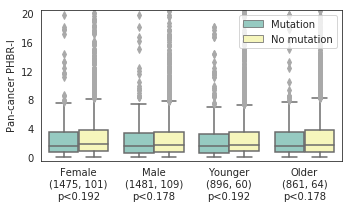

In [32]:
flierprops = dict(markerfacecolor='darkgrey', markersize=5, linestyle='none', markeredgecolor='darkgrey')

# MHC-I
pval_list = get_p_values(mhcI_df, x_parameter='MHC_mutation', y_parameter='scores', 
                         hue='value', sort_on_key=True)

plt.figure(figsize=(5,3))
ax = sns.boxplot(x='value', y='scores', data=mhcI_df, hue='MHC_mutation', 
            order=['female', 'male', 'younger', 'older'], palette='Set3', flierprops=flierprops)

plt.xlabel(''), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1,2,3], ['Female\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='female')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='female')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Male\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='male')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='male')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                pval_list[1][1]),
                   'Younger\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='younger')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='younger')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Older\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='older')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='older')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                pval_list[1][1])])
plt.yticks(range(0,21,4))
plt.ylim(-0.5,20.5)
plt.legend(loc='upper right')
# plt.text(-0.25, 1.1, 'A', transform=ax.transAxes, fontsize=16,  weight='bold')


# save
plt.tight_layout()
savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S4_MHC_mut.sex_PHBR_boxplot.I.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath)

plt.show()

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/S4_MHC_mut.sex_PHBR_boxplot.I.pdf


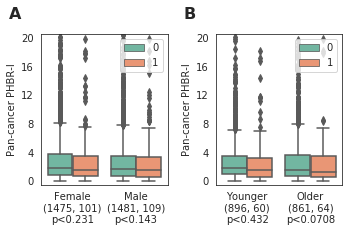

In [18]:
# sex
pval_list = get_p_values(total_confident_patientsI, x_parameter='MHC_mutation', y_parameter='scores', 
                         hue='sex', sort_on_key=True)

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
ax = sns.boxplot(x='sex', y='scores', data=total_confident_patientsI, hue='MHC_mutation', hue_order=[0,1], 
            order=['female', 'male'], palette='Set2')

plt.xlabel(''), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1], ['Female\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='female')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='female')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Male\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='male')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsI[(total_confident_patientsI['sex']=='male')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                pval_list[1][1])])
plt.yticks(range(0,21,4))
plt.ylim(-0.5,20.5)
plt.legend(loc='upper right')
plt.text(-0.25, 1.1, 'A', transform=ax.transAxes, fontsize=16,  weight='bold')


# age
pval_list = get_p_values(total_confident_patientsI, x_parameter='MHC_mutation', y_parameter='scores', 
                         hue='age_categorical_3070', sort_on_key=True)

plt.subplot(1,2,2)
ax = sns.boxplot(x='age_categorical_3070', y='scores', data=total_confident_patientsI, hue='MHC_mutation', hue_order=[0,1], 
            order=['younger', 'older'], palette='Set2')

plt.xlabel(''), plt.ylabel('Pan-cancer PHBR-I')

plt.xticks([0,1], ['Younger\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='younger')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='younger')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Older\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='older')&(total_confident_patientsI['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsI[(total_confident_patientsI['age_categorical_3070']=='older')&(total_confident_patientsI['MHC_mutation']==1)].index)),
                                                pval_list[1][1])])
plt.yticks(range(0,21,4))
plt.ylim(-0.5,20.5)
plt.legend(loc='upper right')
plt.text(-0.25, 1.1, 'B', transform=ax.transAxes, fontsize=16,  weight='bold')

# save
plt.tight_layout()
savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S4_MHC_mut.sex_PHBR_boxplot.I.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath)

plt.show()

##### MHC-II

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/MHC_mut.age_PHBR_boxplot.I.pdf


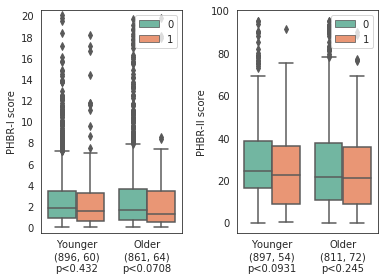

In [38]:
# sex
pval_list = get_p_values(total_confident_patientsII, x_parameter='MHC_mutation', y_parameter='scores', 
                         hue='sex', sort_on_key=True)
plt.subplot(1,2,2)
sns.boxplot(x='sex', y='scores', data=total_confident_patientsII, hue='MHC_mutation', hue_order=[0,1], 
            order=['female', 'male'], palette='Set2')

plt.xlabel('')
plt.ylabel('PHBR-II score')

plt.xticks([0,1], ['Female\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsII[(total_confident_patientsII['sex']=='female')&(total_confident_patientsII['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsII[(total_confident_patientsII['sex']=='female')&(total_confident_patientsII['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Male\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsII[(total_confident_patientsII['sex']=='male')&(total_confident_patientsII['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsII[(total_confident_patientsII['sex']=='male')&(total_confident_patientsII['MHC_mutation']==1)].index)),
                                                pval_list[1][1])])

plt.yticks(range(0,101,20))
plt.legend(loc='upper right')

# age
pval_list = get_p_values(total_confident_patientsII, x_parameter='MHC_mutation', y_parameter='scores', 
                         hue='age_categorical_3070', sort_on_key=True)
plt.subplot(1,2,2)
sns.boxplot(x='age_categorical_3070', y='scores', data=total_confident_patientsII, hue='MHC_mutation', hue_order=[0,1], 
            order=['younger', 'older'], palette='Set2')

plt.xlabel('')
plt.ylabel('PHBR-II score')

plt.xticks([0,1], ['Younger\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsII[(total_confident_patientsII['age_categorical_3070']=='younger')&(total_confident_patientsII['MHC_mutation']==0)].index)),
                                                      len(set(total_confident_patientsII[(total_confident_patientsII['age_categorical_3070']=='younger')&(total_confident_patientsII['MHC_mutation']==1)].index)),
                                                      pval_list[0][1]), 
                   'Older\n({}, {})\np<{:.3}'.format(len(set(total_confident_patientsII[(total_confident_patientsII['age_categorical_3070']=='older')&(total_confident_patientsII['MHC_mutation']==0)].index)),
                                                len(set(total_confident_patientsII[(total_confident_patientsII['age_categorical_3070']=='older')&(total_confident_patientsII['MHC_mutation']==1)].index)),
                                                pval_list[1][1])])

plt.yticks(range(0,101,20))
plt.legend(loc='upper right')

plt.tight_layout()
savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/MHC_mut.age_PHBR_boxplot.I.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath)

plt.show()